In [3]:
pip install neptune-client

In [4]:
pip install scikit-plot

In [5]:
import pandas as pd
import numpy as np


from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
#import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve


In [6]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [7]:
import neptune

API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmM4OTBkYTAtY2JlYi00MGM4LWIzZTUtYzg1MTJkMzJkYjk3In0=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [8]:
raw_train.head()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,31,0,0,0,1,0
3,14559326134688,0,21,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,5,0,0,1,0,0
4,16796474433112,0,39,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,4,0,0,0,1,1


In [9]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [10]:
feats = ['PatientId',
 	'Gender',
  'Age', 	
  'Neighbourhood_0', 	
  'Neighbourhood_1', 	
  'Neighbourhood_2', 	
  'Neighbourhood_3',	
  'Neighbourhood_4', 	
  'Neighbourhood_5', 
  'Neighbourhood_6', 
  'Neighbourhood_7',	
  'Scholarship', 	
  'Hypertension', 	
  'Diabetes', 	
  'Alcoholism', 	
  'Handicap', 	
  'SMSReceived', 	
  'MonthBookingDate_0', 	
  'MonthBookingDate_1',	
  'MonthBookingDate_2', 	
  'MonthBookingDate_3', 	
  'DayBookingDate_0', 	
  'DayBookingDate_1',	
  'DayBookingDate_2',	
  'DayBookingDate_3', 	
  'DayBookingDate_4', 	
  'DayBookingDate_5', 	
  'MonthAppointmentDate_0', 	
  'MonthAppointmentDate_1', 	
  'MonthAppointmentDate_2', 	
  'DayAppointmentDate_0',	
  'DayAppointmentDate_1',	
  'DayAppointmentDate_2',	
  'DayAppointmentDate_3', 	
  'DayAppointmentDate_4',
  'DayAppointmentDate_5', 	
  'HourOfDayBooking_0', 	
  'DaysToAppointment', 	
  'AppointmentWeekDay_0', 	
  'AppointmentWeekDay_1', 	
  'AppointmentWeekDay_2', 	
  'AppointmentWeekDay_3']

In [11]:
X_raw = get_X(raw_train)
y_raw = get_y(raw_train)

In [12]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

In [13]:
def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

In [14]:
def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

In [15]:
def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [16]:
def split_data(train, test):
    feats = train.columns[:-1]
    
    X_train = train[feats]
    X_test = test[feats]
    
    y_train = train['NoShow']
    y_test = test["NoShow"]
    return X_train, y_train, X_test, y_test

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [18]:
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB(),

}

In [19]:
def run_model(model, train, test, name, tags):
    X_train, y_train, X_test, y_test = split_data(train, test)
    
    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))
    
    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1');    
    plt.show()
    neptune.stop()

In [27]:
tags =['NaiveBayes', 'Raw']

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-348
[0 0 0 ... 0 0 0] 

accuracy:  0.7981081204588036
recall:  0.0
precision:  0.0
f1:  0.0
ROC AUC:  0.5 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17465
           1       0.00      0.00      0.00      4418

    accuracy                           0.80     21883
   macro avg       0.40      0.50      0.44     21883
weighted avg       0.64      0.80      0.71     21883



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


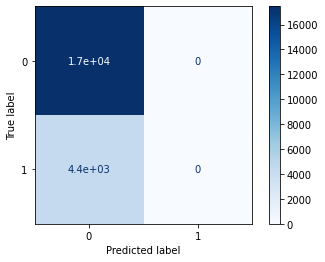

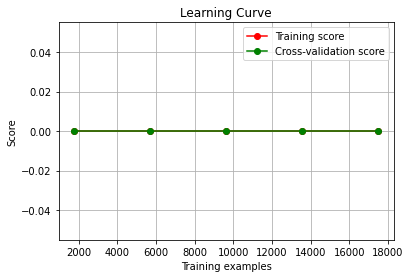

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-349
[1 0 0 ... 0 0 0] 

accuracy:  0.6836813965178449
recall:  0.49434133091896787
precision:  0.3178114086146682
f1:  0.38689105403011514
ROC AUC:  0.6129593857572223 

              precision    recall  f1-score   support

           0       0.85      0.73      0.79     17465
           1       0.32      0.49      0.39      4418

    accuracy                           0.68     21883
   macro avg       0.58      0.61      0.59     21883
weighted avg       0.74      0.68      0.71     21883



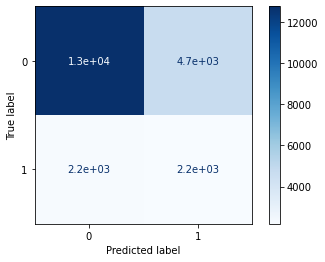

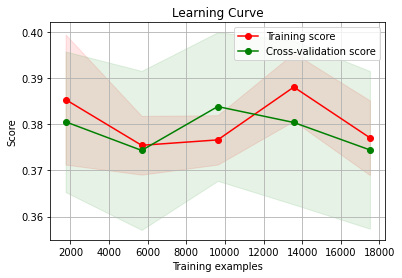

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-350
[1 0 0 ... 0 0 0] 

accuracy:  0.6655394598546818
recall:  0.5520597555454957
precision:  0.3135364442730428
f1:  0.39993441010084446
ROC AUC:  0.6231526948354448 

              precision    recall  f1-score   support

           0       0.86      0.69      0.77     17465
           1       0.31      0.55      0.40      4418

    accuracy                           0.67     21883
   macro avg       0.59      0.62      0.58     21883
weighted avg       0.75      0.67      0.69     21883



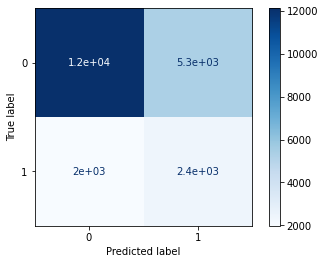

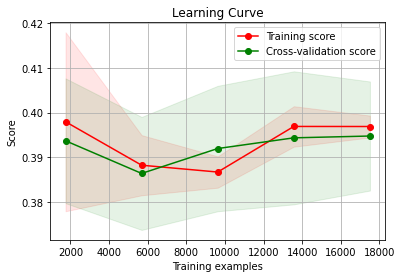

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-351
[0 0 0 ... 0 0 0] 

accuracy:  0.7634693597769958
recall:  0.13784517881394295
precision:  0.3081983805668016
f1:  0.1904910853925555
ROC AUC:  0.5297871757224596 

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     17465
           1       0.31      0.14      0.19      4418

    accuracy                           0.76     21883
   macro avg       0.56      0.53      0.53     21883
weighted avg       0.71      0.76      0.73     21883



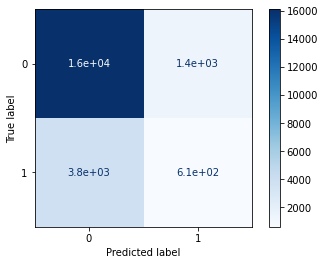

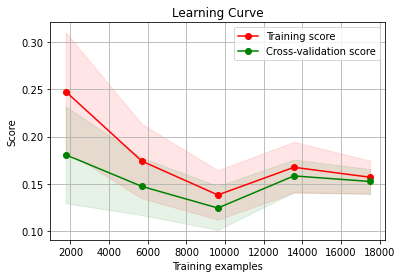

CategoricalNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-352


MemoryError: ignored

In [44]:
tags =['NaiveBayes', 'Raw']
for model in models.items():
    print(model[0])
    run_model(model[1], raw_train, raw_test, model[0], tags)

In [29]:
def run_model2(model, train, test, name, tags):
    X_train, y_train, X_test, y_test = split_data(train, test)
    
    neptune.create_experiment(
        name=name
    )
    
    model = model.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))
    
    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1');    
    plt.show()
    neptune.stop()

In [30]:
run_model2(CategoricalNB(), raw_train, raw_test, 'CategoricalNB', tags)

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-354


MemoryError: ignored

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-355
[0 0 0 ... 0 0 0] 

accuracy:  0.6095518334087823
recall:  0.2206880941602535
precision:  0.9928716904276986
f1:  0.3611111111111111
ROC AUC:  0.6095518334087823 

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      4418
           1       0.99      0.22      0.36      4418

    accuracy                           0.61      8836
   macro avg       0.78      0.61      0.54      8836
weighted avg       0.78      0.61      0.54      8836



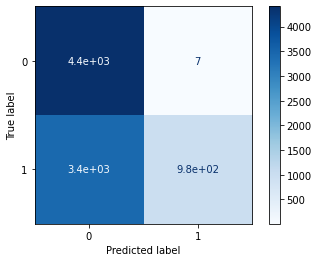

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

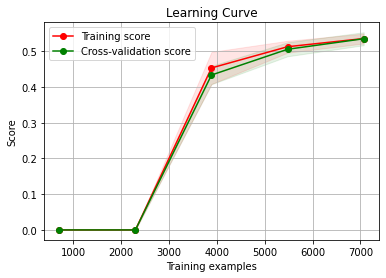

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-356
[1 1 0 ... 0 0 0] 

accuracy:  0.7256677229515618
recall:  0.45948392937980986
precision:  0.9825750242013552
f1:  0.6261566933991364
ROC AUC:  0.7256677229515618 

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      4418
           1       0.98      0.46      0.63      4418

    accuracy                           0.73      8836
   macro avg       0.81      0.73      0.70      8836
weighted avg       0.81      0.73      0.70      8836



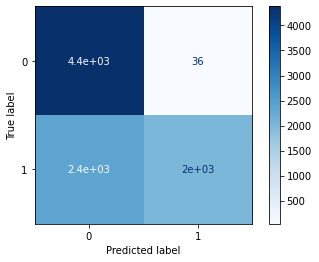

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

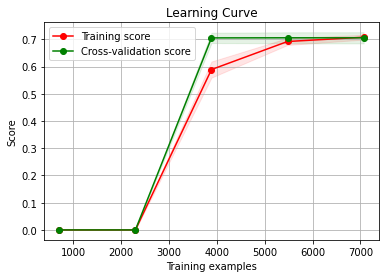

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-357
[1 1 0 ... 0 0 0] 

accuracy:  0.7256677229515618
recall:  0.45948392937980986
precision:  0.9825750242013552
f1:  0.6261566933991364
ROC AUC:  0.7256677229515618 

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      4418
           1       0.98      0.46      0.63      4418

    accuracy                           0.73      8836
   macro avg       0.81      0.73      0.70      8836
weighted avg       0.81      0.73      0.70      8836



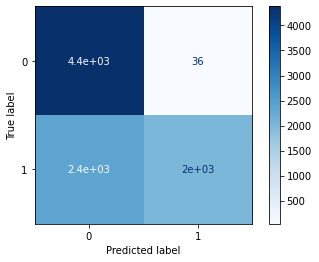

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

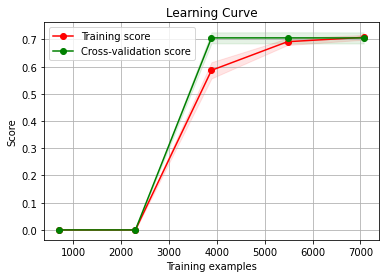

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-358
[0 0 0 ... 0 1 1] 

accuracy:  0.6491625169760072
recall:  0.7523766410140335
precision:  0.623639774859287
f1:  0.6819860484201887
ROC AUC:  0.6491625169760071 

              precision    recall  f1-score   support

           0       0.69      0.55      0.61      4418
           1       0.62      0.75      0.68      4418

    accuracy                           0.65      8836
   macro avg       0.66      0.65      0.65      8836
weighted avg       0.66      0.65      0.65      8836



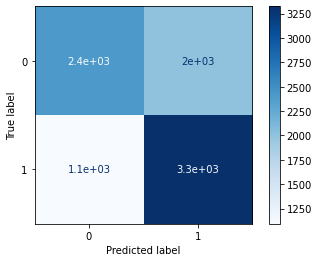

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

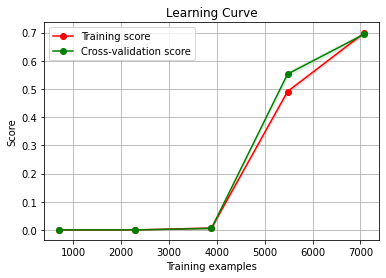

In [31]:
tags =['NaiveBayes', 'Nearmiss']
for model in models.items():
    print(model[0])
    run_model(model[1], Nearmiss_train, Nearmiss_test, model[0], tags)

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-363
[1 1 1 ... 0 1 1] 

accuracy:  0.5023189235614085
recall:  0.8257658173489837
precision:  0.501408058964642
f1:  0.623950852297309
ROC AUC:  0.5023189235614085 

              precision    recall  f1-score   support

           0       0.51      0.18      0.26     17465
           1       0.50      0.83      0.62     17465

    accuracy                           0.50     34930
   macro avg       0.50      0.50      0.44     34930
weighted avg       0.50      0.50      0.44     34930



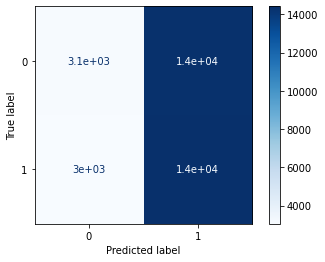

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


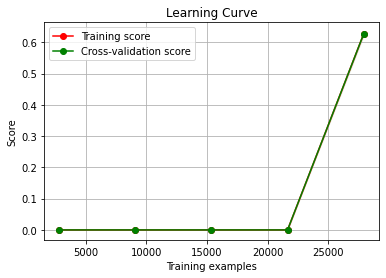

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-364
[1 0 0 ... 0 1 1] 

accuracy:  0.627798454050959
recall:  0.5772688233610077
precision:  0.6421656050955414
f1:  0.6079903512739334
ROC AUC:  0.627798454050959 

              precision    recall  f1-score   support

           0       0.62      0.68      0.65     17465
           1       0.64      0.58      0.61     17465

    accuracy                           0.63     34930
   macro avg       0.63      0.63      0.63     34930
weighted avg       0.63      0.63      0.63     34930



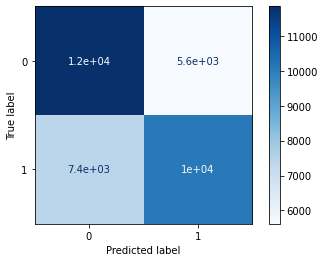

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


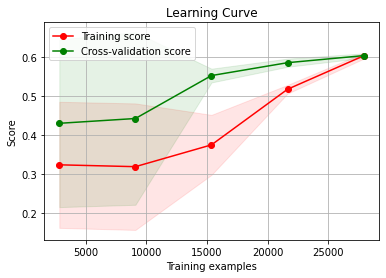

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-365
[1 0 0 ... 0 1 1] 

accuracy:  0.6245061551674778
recall:  0.5614085313484111
precision:  0.6424873861476967
f1:  0.5992177473568417
ROC AUC:  0.6245061551674779 

              precision    recall  f1-score   support

           0       0.61      0.69      0.65     17465
           1       0.64      0.56      0.60     17465

    accuracy                           0.62     34930
   macro avg       0.63      0.62      0.62     34930
weighted avg       0.63      0.62      0.62     34930



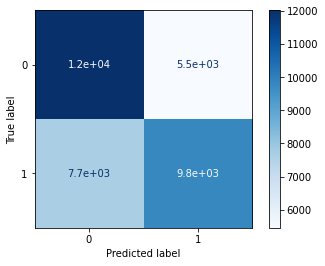

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


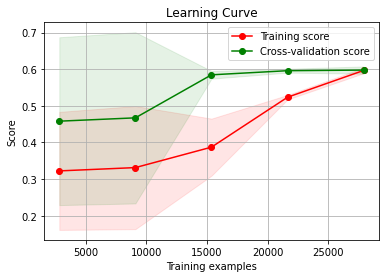

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-366
[1 0 0 ... 0 1 1] 

accuracy:  0.6537074148296593
recall:  0.7737188663040366
precision:  0.6239553031352449
f1:  0.6908133531005572
ROC AUC:  0.6537074148296593 

              precision    recall  f1-score   support

           0       0.70      0.53      0.61     17465
           1       0.62      0.77      0.69     17465

    accuracy                           0.65     34930
   macro avg       0.66      0.65      0.65     34930
weighted avg       0.66      0.65      0.65     34930



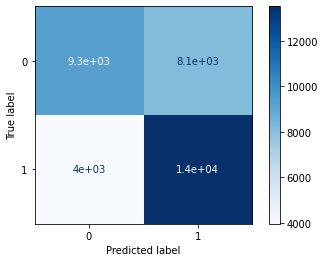

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


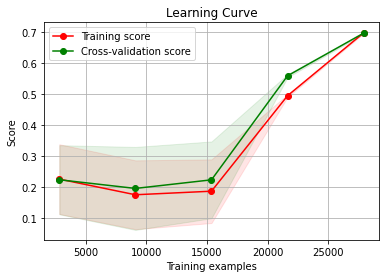

In [21]:
tags =['NaiveBayes', 'ROS']
for model in models.items():
    print(model[0])
    run_model(model[1], ROS_train, ROS_test, model[0], tags)

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-367
[1 1 1 ... 1 1 1] 

accuracy:  0.5020371208691715
recall:  0.8277501131733817
precision:  0.501233552631579
f1:  0.624381082465426
ROC AUC:  0.5020371208691715 

              precision    recall  f1-score   support

           0       0.51      0.18      0.26      4418
           1       0.50      0.83      0.62      4418

    accuracy                           0.50      8836
   macro avg       0.50      0.50      0.44      8836
weighted avg       0.50      0.50      0.44      8836



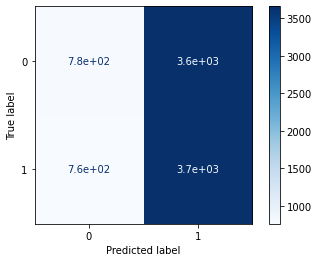

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

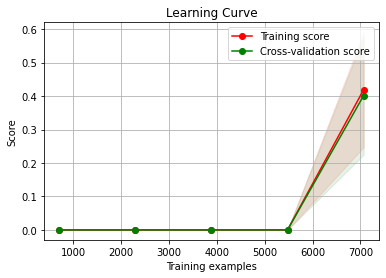

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-368
[1 1 0 ... 0 1 1] 

accuracy:  0.6212086917157085
recall:  0.5531914893617021
precision:  0.6402934241550956
f1:  0.5935640558591379
ROC AUC:  0.6212086917157085 

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      4418
           1       0.64      0.55      0.59      4418

    accuracy                           0.62      8836
   macro avg       0.62      0.62      0.62      8836
weighted avg       0.62      0.62      0.62      8836



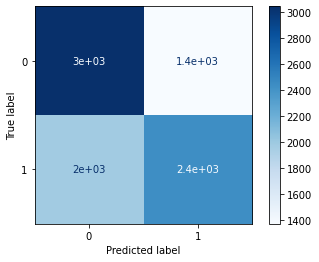

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

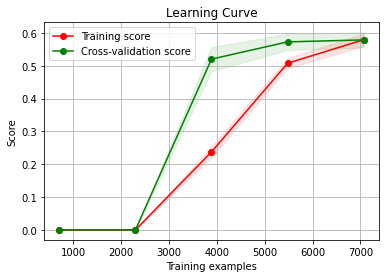

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-369
[1 1 0 ... 0 1 1] 

accuracy:  0.6196242643730194
recall:  0.5484382073336351
precision:  0.6394827131169174
f1:  0.5904715486779578
ROC AUC:  0.6196242643730194 

              precision    recall  f1-score   support

           0       0.60      0.69      0.64      4418
           1       0.64      0.55      0.59      4418

    accuracy                           0.62      8836
   macro avg       0.62      0.62      0.62      8836
weighted avg       0.62      0.62      0.62      8836



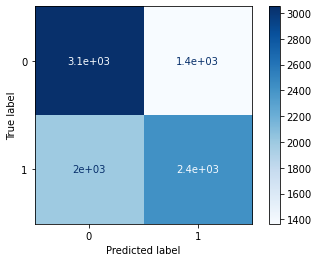

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/pytho

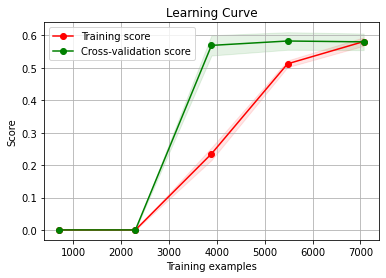

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-370
[0 1 0 ... 0 1 1] 

accuracy:  0.6466727025803531
recall:  0.7802172928927117
precision:  0.6157556270096463
f1:  0.6882987220447285
ROC AUC:  0.6466727025803531 

              precision    recall  f1-score   support

           0       0.70      0.51      0.59      4418
           1       0.62      0.78      0.69      4418

    accuracy                           0.65      8836
   macro avg       0.66      0.65      0.64      8836
weighted avg       0.66      0.65      0.64      8836



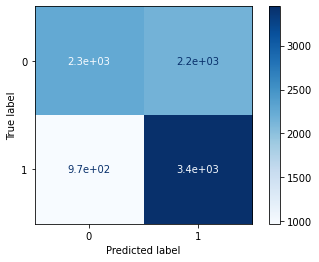

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

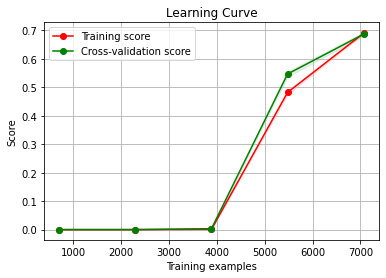

In [22]:
tags =['NaiveBayes', 'RUS']
for model in models.items():
    print(model[0])
    run_model(model[1], RUS_train, RUS_test, model[0], tags)

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-371
[1 1 1 ... 1 1 1] 

accuracy:  0.5041802308375259
recall:  0.8329387392719739
precision:  0.5025219836629022
f1:  0.6268548678972131
ROC AUC:  0.5041802308375258 

              precision    recall  f1-score   support

           0       0.51      0.18      0.26     13516
           1       0.50      0.83      0.63     13516

    accuracy                           0.50     27032
   macro avg       0.51      0.50      0.44     27032
weighted avg       0.51      0.50      0.44     27032



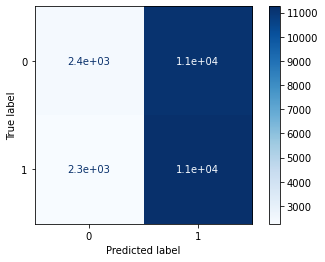

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


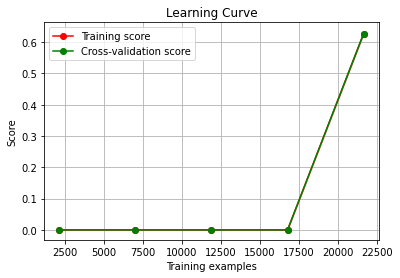

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-372
[1 0 0 ... 1 0 0] 

accuracy:  0.6780852323172536
recall:  0.5973660846404262
precision:  0.7123698605964355
f1:  0.6498189134808853
ROC AUC:  0.6780852323172537 

              precision    recall  f1-score   support

           0       0.65      0.76      0.70     13516
           1       0.71      0.60      0.65     13516

    accuracy                           0.68     27032
   macro avg       0.68      0.68      0.68     27032
weighted avg       0.68      0.68      0.68     27032



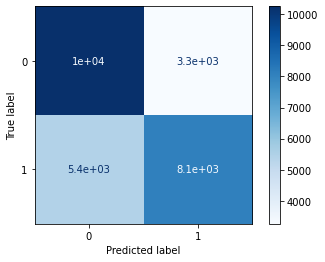

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


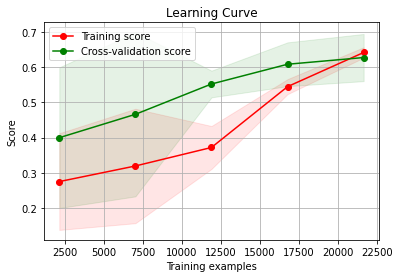

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-373
[1 0 0 ... 1 0 0] 

accuracy:  0.6780112459307488
recall:  0.5988458123705238
precision:  0.7114978902953587
f1:  0.6503294231078259
ROC AUC:  0.6780112459307487 

              precision    recall  f1-score   support

           0       0.65      0.76      0.70     13516
           1       0.71      0.60      0.65     13516

    accuracy                           0.68     27032
   macro avg       0.68      0.68      0.68     27032
weighted avg       0.68      0.68      0.68     27032



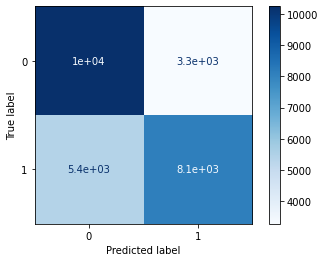

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


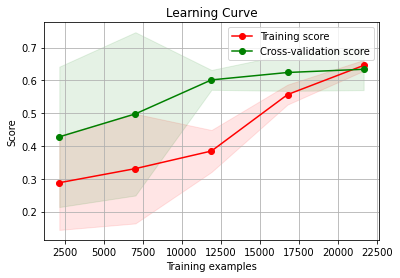

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-374
[0 0 0 ... 1 1 1] 

accuracy:  0.8257250665877478
recall:  0.8074874223142942
precision:  0.8380557475236121
f1:  0.8224876596706734
ROC AUC:  0.8257250665877479 

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     13516
           1       0.84      0.81      0.82     13516

    accuracy                           0.83     27032
   macro avg       0.83      0.83      0.83     27032
weighted avg       0.83      0.83      0.83     27032



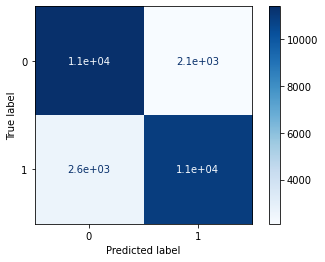

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


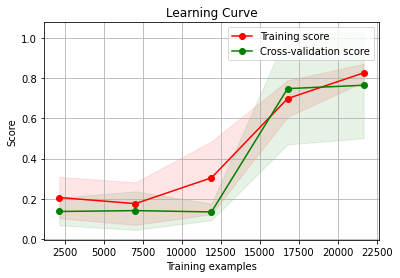

In [23]:
tags =['NaiveBayes', 'SMOTETomek']
for model in models.items():
    print(model[0])
    run_model(model[1], SMOTETomek_train, SMOTETomek_test, model[0], tags)

GaussianNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-375
[1 1 1 ... 1 1 1] 

accuracy:  0.4994132295274351
recall:  0.7909226190476191
precision:  0.49969264147532094
f1:  0.6124493097258847
ROC AUC:  0.4993548108121004 

              precision    recall  f1-score   support

           0       0.50      0.21      0.29     17465
           1       0.50      0.79      0.61     17472

    accuracy                           0.50     34937
   macro avg       0.50      0.50      0.45     34937
weighted avg       0.50      0.50      0.45     34937



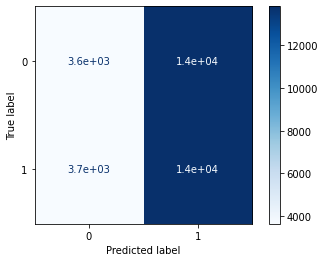

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


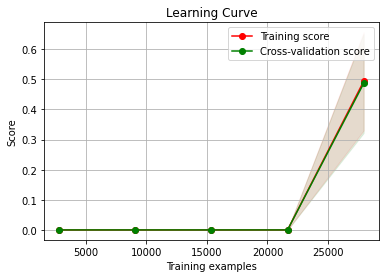

MultinomialNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-376
[1 0 0 ... 0 1 1] 

accuracy:  0.6695194206714944
recall:  0.5653617216117216
precision:  0.7142443962400579
f1:  0.6311417800779503
ROC AUC:  0.6695402939578792 

              precision    recall  f1-score   support

           0       0.64      0.77      0.70     17465
           1       0.71      0.57      0.63     17472

    accuracy                           0.67     34937
   macro avg       0.68      0.67      0.67     34937
weighted avg       0.68      0.67      0.67     34937



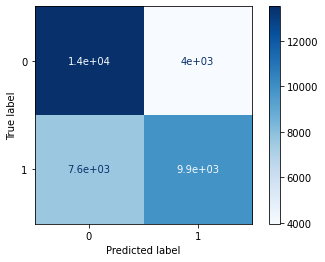

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


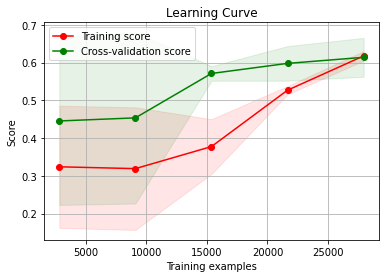

ComplementNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-377
[1 0 0 ... 0 1 1] 

accuracy:  0.6770472564902539
recall:  0.5904304029304029
precision:  0.7142560409887142
f1:  0.6464671784427385
ROC AUC:  0.6770646145771396 

              precision    recall  f1-score   support

           0       0.65      0.76      0.70     17465
           1       0.71      0.59      0.65     17472

    accuracy                           0.68     34937
   macro avg       0.68      0.68      0.67     34937
weighted avg       0.68      0.68      0.67     34937



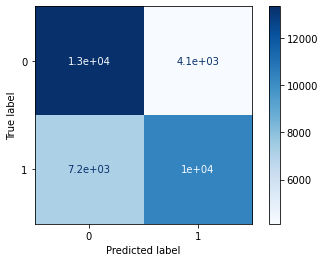

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:868: RuntimeWarning: divide by zero encountered in log
  logged = np.log(comp_count / comp_count.sum(axis=1, keepdims=True))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


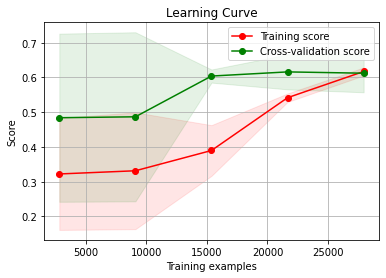

BernoulliNB
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-378
[0 0 0 ... 1 1 1] 

accuracy:  0.8122334487792312
recall:  0.7917239010989011
precision:  0.8256535752656082
f1:  0.8083328463741015
ROC AUC:  0.8122375589090268 

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     17465
           1       0.83      0.79      0.81     17472

    accuracy                           0.81     34937
   macro avg       0.81      0.81      0.81     34937
weighted avg       0.81      0.81      0.81     34937



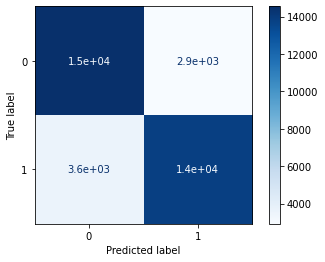

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


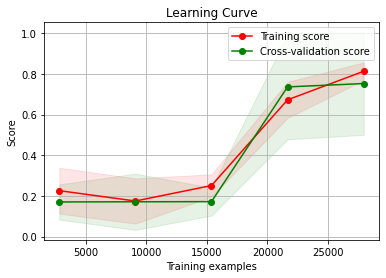

In [24]:
tags =['NaiveBayes', 'Adasyn']
for model in models.items():
    print(model[0])
    run_model(model[1], Adasyn_train, Adasyn_test, model[0], tags)

Literatura:
Marcin Szeliga, Data Science i uczenie maszynowe

https://scikit-learn.org/stable/modules/neighbors.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid

https://pl.wikipedia.org/wiki/Centroid

